In [1]:
import glob
import sys
import csv
import cv2
import time
import os
import argparse
import itertools
from multiprocessing import Pool
import threading
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon

import tensorflow as tf


c:\Users\farra\anaconda3\envs\tf_win_gpu\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

In [3]:
min_crop_side_ratio = 0.1
min_text_size = 10

In [4]:
def get_images(data_path):
  files = []
  idx = 0
  for ext in ['jpg', 'png', 'jpeg', 'JPG']:
    files.extend(glob.glob(
      os.path.join(data_path, '*.{}'.format(ext))))
    idx += 1
  return files

def get_text_file(image_file):
  txt_file = image_file.replace(os.path.basename(image_file).split('.')[1], 'txt')
  # print(txt_file)
  txt_file_name = os.path.split(txt_file)[1]
  txt_file = txt_file.replace(txt_file_name, 'gt_' + txt_file_name)
  return txt_file

def load_annotation(p):
  '''
  load annotation from the text file
  :param p:
  :return:
  '''
  text_polys = []
  text_tags = []
  if not os.path.exists(p):
    return np.array(text_polys, dtype=np.float32)
  with open(p, 'r') as f:
    reader = csv.reader(f)
    for line in reader:
      label = line[-1]
      # strip BOM. \ufeff for python3,  \xef\xbb\bf for python2
      line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]

      x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
      text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
      if label == '*' or label == '###':
        text_tags.append(True)
      else:
        text_tags.append(False)
    return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool_)
  
def polygon_area(poly):
  '''
  compute area of a polygon
  :param poly:
  :return:
  '''
  edge = [
    (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
    (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
    (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
    (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
  ]
  return np.sum(edge)/2.
  
def check_and_validate_polys(polys, tags, size):
  '''
  check so that the text poly is in the same direction,
  and also filter some invalid polygons
  :param polys:
  :param tags:
  :return:
  '''
  (h, w) = size
  if polys.shape[0] == 0:
    return polys
  polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
  polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

  validated_polys = []
  validated_tags = []
  for poly, tag in zip(polys, tags):
    p_area = polygon_area(poly)
    if abs(p_area) < 1:
      # print poly
      # if not FLAGS.suppress_warnings_and_error_messages:
      print('invalid poly')
      continue
    if p_area > 0:
      # if not FLAGS.suppress_warnings_and_error_messages:
      print('poly in wrong direction')
      poly = poly[(0, 3, 2, 1), :]
    validated_polys.append(poly)
    validated_tags.append(tag)
  return np.array(validated_polys), np.array(validated_tags)


def crop_area(im, polys, tags, crop_background=False, max_tries=50):
  '''
  make random crop from the input image
  :param im:
  :param polys:
  :param tags:
  :param crop_background:
  :param max_tries:
  :return:
  '''
  h, w, _ = im.shape
  pad_h = h//10
  pad_w = w//10
  h_array = np.zeros((h + pad_h*2), dtype=np.int32)
  w_array = np.zeros((w + pad_w*2), dtype=np.int32)
  for poly in polys:
    poly = np.round(poly, decimals=0).astype(np.int32)
    minx = np.min(poly[:, 0])
    maxx = np.max(poly[:, 0])
    w_array[minx+pad_w:maxx+pad_w] = 1
    miny = np.min(poly[:, 1])
    maxy = np.max(poly[:, 1])
    h_array[miny+pad_h:maxy+pad_h] = 1
  # ensure the cropped area not across a text
  h_axis = np.where(h_array == 0)[0]
  w_axis = np.where(w_array == 0)[0]
  if len(h_axis) == 0 or len(w_axis) == 0:
    return im, polys, tags
  for i in range(max_tries):
    xx = np.random.choice(w_axis, size=2)
    xmin = np.min(xx) - pad_w
    xmax = np.max(xx) - pad_w
    xmin = np.clip(xmin, 0, w-1)
    xmax = np.clip(xmax, 0, w-1)
    yy = np.random.choice(h_axis, size=2)
    ymin = np.min(yy) - pad_h
    ymax = np.max(yy) - pad_h
    ymin = np.clip(ymin, 0, h-1)
    ymax = np.clip(ymax, 0, h-1)
    if xmax - xmin < min_crop_side_ratio*w or ymax - ymin < min_crop_side_ratio*h:
      # area too small
      continue
    if polys.shape[0] != 0:
      poly_axis_in_area = (polys[:, :, 0] >= xmin) & (polys[:, :, 0] <= xmax) \
                          & (polys[:, :, 1] >= ymin) & (polys[:, :, 1] <= ymax)
      selected_polys = np.where(np.sum(poly_axis_in_area, axis=1) == 4)[0]
    else:
      selected_polys = []
    if len(selected_polys) == 0:
      # no text in this area
      if crop_background:
        return im[ymin:ymax+1, xmin:xmax+1, :], polys[selected_polys], tags[selected_polys]
      else:
        continue
    im = im[ymin:ymax+1, xmin:xmax+1, :]
    polys = polys[selected_polys]
    tags = tags[selected_polys]
    polys[:, :, 0] -= xmin
    polys[:, :, 1] -= ymin
    return im, polys, tags

  return im, polys, tags

def pad_image(img, input_size, is_train):
  new_h, new_w, _ = img.shape
  max_h_w_i = np.max([new_h, new_w, input_size])
  img_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
  if is_train:
    shift_h = np.random.randint(max_h_w_i - new_h + 1)
    shift_w = np.random.randint(max_h_w_i - new_w + 1)
  else:
    shift_h = (max_h_w_i - new_h) // 2
    shift_w = (max_h_w_i - new_w) // 2
  img_padded[shift_h:new_h+shift_h, shift_w:new_w+shift_w, :] = img.copy()
  img = img_padded
  return img, shift_h, shift_w

def resize_image(img, text_polys, input_size, shift_h, shift_w):
  new_h, new_w, _ = img.shape
  img = cv2.resize(img, dsize=(input_size, input_size))
  # pad and resize text polygons
  resize_ratio_3_x = input_size/float(new_w)
  resize_ratio_3_y = input_size/float(new_h)
  text_polys[:, :, 0] += shift_w
  text_polys[:, :, 1] += shift_h
  text_polys[:, :, 0] *= resize_ratio_3_x
  text_polys[:, :, 1] *= resize_ratio_3_y
  return img, text_polys

def shrink_poly(poly, r):
  '''
  fit a poly inside the origin poly, maybe bugs here...
  used for generating the score map
  :param poly: the text poly
  :param r: r in the paper
  :return: the shrinked poly
  '''
  # shrink ratio
  R = 0.3
  # find the longer pair
  if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
          np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
    # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
    ## p0, p1
    theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
    poly[0][0] += R * r[0] * np.cos(theta)
    poly[0][1] += R * r[0] * np.sin(theta)
    poly[1][0] -= R * r[1] * np.cos(theta)
    poly[1][1] -= R * r[1] * np.sin(theta)
    ## p2, p3
    theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
    poly[3][0] += R * r[3] * np.cos(theta)
    poly[3][1] += R * r[3] * np.sin(theta)
    poly[2][0] -= R * r[2] * np.cos(theta)
    poly[2][1] -= R * r[2] * np.sin(theta)
    ## p0, p3
    theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
    poly[0][0] += R * r[0] * np.sin(theta)
    poly[0][1] += R * r[0] * np.cos(theta)
    poly[3][0] -= R * r[3] * np.sin(theta)
    poly[3][1] -= R * r[3] * np.cos(theta)
    ## p1, p2
    theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
    poly[1][0] += R * r[1] * np.sin(theta)
    poly[1][1] += R * r[1] * np.cos(theta)
    poly[2][0] -= R * r[2] * np.sin(theta)
    poly[2][1] -= R * r[2] * np.cos(theta)
  else:
    ## p0, p3
    # print poly
    theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
    poly[0][0] += R * r[0] * np.sin(theta)
    poly[0][1] += R * r[0] * np.cos(theta)
    poly[3][0] -= R * r[3] * np.sin(theta)
    poly[3][1] -= R * r[3] * np.cos(theta)
    ## p1, p2
    theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
    poly[1][0] += R * r[1] * np.sin(theta)
    poly[1][1] += R * r[1] * np.cos(theta)
    poly[2][0] -= R * r[2] * np.sin(theta)
    poly[2][1] -= R * r[2] * np.cos(theta)
    ## p0, p1
    theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
    poly[0][0] += R * r[0] * np.cos(theta)
    poly[0][1] += R * r[0] * np.sin(theta)
    poly[1][0] -= R * r[1] * np.cos(theta)
    poly[1][1] -= R * r[1] * np.sin(theta)
    ## p2, p3
    theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
    poly[3][0] += R * r[3] * np.cos(theta)
    poly[3][1] += R * r[3] * np.sin(theta)
    poly[2][0] -= R * r[2] * np.cos(theta)
    poly[2][1] -= R * r[2] * np.sin(theta)
  return poly


def point_dist_to_line(p1, p2, p3):
  # compute the distance from p3 to p1-p2
  return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)


def fit_line(p1, p2):
  # fit a line ax+by+c = 0
  if p1[0] == p1[1]:
    return [1., 0., -p1[0]]
  else:
    [k, b] = np.polyfit(p1, p2, deg=1)
    return [k, -1., b]


def line_cross_point(line1, line2):
  # line1 0= ax+by+c, compute the cross point of line1 and line2
  if line1[0] != 0 and line1[0] == line2[0]:
    # if not FLAGS.suppress_warnings_and_error_messages:
    print('Cross point does not exist')
    return None
  if line1[0] == 0 and line2[0] == 0:
    # if not FLAGS.suppress_warnings_and_error_messages:
    print('Cross point does not exist')
    return None
  if line1[1] == 0:
    x = -line1[2]
    y = line2[0] * x + line2[2]
  elif line2[1] == 0:
    x = -line2[2]
    y = line1[0] * x + line1[2]
  else:
    k1, _, b1 = line1
    k2, _, b2 = line2
    x = -(b1-b2)/(k1-k2)
    y = k1*x + b1
  return np.array([x, y], dtype=np.float32)


def line_verticle(line, point):
  # get the verticle line from line across point
  if line[1] == 0:
    verticle = [0, -1, point[1]]
  else:
    if line[0] == 0:
      verticle = [1, 0, -point[0]]
    else:
      verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
  return verticle


def rectangle_from_parallelogram(poly):
  '''
  fit a rectangle from a parallelogram
  :param poly:
  :return:
  '''
  p0, p1, p2, p3 = poly
  angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
  if angle_p0 < 0.5 * np.pi:
    if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
      # p0 and p2
      ## p0
      p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
      p2p3_verticle = line_verticle(p2p3, p0)

      new_p3 = line_cross_point(p2p3, p2p3_verticle)
      ## p2
      p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
      p0p1_verticle = line_verticle(p0p1, p2)

      new_p1 = line_cross_point(p0p1, p0p1_verticle)
      return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
      p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
      p1p2_verticle = line_verticle(p1p2, p0)

      new_p1 = line_cross_point(p1p2, p1p2_verticle)
      p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
      p0p3_verticle = line_verticle(p0p3, p2)

      new_p3 = line_cross_point(p0p3, p0p3_verticle)
      return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
  else:
    if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
      # p1 and p3
      ## p1
      p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
      p2p3_verticle = line_verticle(p2p3, p1)

      new_p2 = line_cross_point(p2p3, p2p3_verticle)
      ## p3
      p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
      p0p1_verticle = line_verticle(p0p1, p3)

      new_p0 = line_cross_point(p0p1, p0p1_verticle)
      return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
    else:
      p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
      p0p3_verticle = line_verticle(p0p3, p1)

      new_p0 = line_cross_point(p0p3, p0p3_verticle)
      p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
      p1p2_verticle = line_verticle(p1p2, p3)

      new_p2 = line_cross_point(p1p2, p1p2_verticle)
      return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)


def sort_rectangle(poly):
  # sort the four coordinates of the polygon, points in poly should be sorted clockwise
  # First find the lowest point
  p_lowest = np.argmax(poly[:, 1])
  if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
    # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
    p0_index = np.argmin(np.sum(poly, axis=1))
    p1_index = (p0_index + 1) % 4
    p2_index = (p0_index + 2) % 4
    p3_index = (p0_index + 3) % 4
    return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
  else:
    # find the point that sits right to the lowest point
    p_lowest_right = (p_lowest - 1) % 4
    p_lowest_left = (p_lowest + 1) % 4
    angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
    # assert angle > 0
    if angle <= 0:
      # if not FLAGS.suppress_warnings_and_error_messages:
        print(angle, poly[p_lowest], poly[p_lowest_right])
    if angle/np.pi * 180 > 45:
      #  this point is p2
      p2_index = p_lowest
      p1_index = (p2_index - 1) % 4
      p0_index = (p2_index - 2) % 4
      p3_index = (p2_index + 1) % 4
      return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
    else:
      #  this point is p3
      p3_index = p_lowest
      p0_index = (p3_index + 1) % 4
      p1_index = (p3_index + 2) % 4
      p2_index = (p3_index + 3) % 4
      return poly[[p0_index, p1_index, p2_index, p3_index]], angle


def restore_rectangle_rbox(origin, geometry):
  d = geometry[:, :4]
  angle = geometry[:, 4]
  # for angle > 0
  origin_0 = origin[angle >= 0]
  d_0 = d[angle >= 0]
  angle_0 = angle[angle >= 0]
  if origin_0.shape[0] > 0:
    p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                  d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                  d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                  np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                  d_0[:, 3], -d_0[:, 2]])
    p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

    rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
    rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

    rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
    rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

    p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
    p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

    p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

    p3_in_origin = origin_0 - p_rotate[:, 4, :]
    new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
    new_p1 = p_rotate[:, 1, :] + p3_in_origin
    new_p2 = p_rotate[:, 2, :] + p3_in_origin
    new_p3 = p_rotate[:, 3, :] + p3_in_origin

    new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                              new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
  else:
    new_p_0 = np.zeros((0, 4, 2))
  # for angle < 0
  origin_1 = origin[angle < 0]
  d_1 = d[angle < 0]
  angle_1 = angle[angle < 0]
  if origin_1.shape[0] > 0:
    p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                  np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                  np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                  -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                  -d_1[:, 1], -d_1[:, 2]])
    p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

    rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
    rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

    rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
    rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

    p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
    p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

    p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

    p3_in_origin = origin_1 - p_rotate[:, 4, :]
    new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
    new_p1 = p_rotate[:, 1, :] + p3_in_origin
    new_p2 = p_rotate[:, 2, :] + p3_in_origin
    new_p3 = p_rotate[:, 3, :] + p3_in_origin

    new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                              new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
  else:
    new_p_1 = np.zeros((0, 4, 2))
  return np.concatenate([new_p_0, new_p_1])


def restore_rectangle(origin, geometry):
  return restore_rectangle_rbox(origin, geometry)

def generate_rbox(im_size, polys, tags, geometry=None):
  h, w = im_size
  shrinked_poly_mask = np.zeros((h, w), dtype=np.uint8)
  orig_poly_mask = np.zeros((h, w), dtype=np.uint8)
  score_map = np.zeros((h, w), dtype=np.uint8)
  geo_map = np.zeros((h, w, 5), dtype=np.float32)
  # mask used during traning, to ignore some hard areas
  overly_small_text_region_training_mask = np.ones((h, w), dtype=np.uint8)
  for poly_idx, poly_data in enumerate(zip(polys, tags)):
    poly = poly_data[0]
    tag = poly_data[1]

    r = [None, None, None, None]
    for i in range(4):
      r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                 np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
    # score map
    shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
    cv2.fillPoly(score_map, shrinked_poly, 1)
    cv2.fillPoly(shrinked_poly_mask, shrinked_poly, poly_idx + 1)
    cv2.fillPoly(orig_poly_mask, poly.astype(np.int32)[np.newaxis, :, :], 1)
    # if the poly is too small, then ignore it during training
    poly_h = min(np.linalg.norm(poly[0] - poly[3]), np.linalg.norm(poly[1] - poly[2]))
    poly_w = min(np.linalg.norm(poly[0] - poly[1]), np.linalg.norm(poly[2] - poly[3]))
    if min(poly_h, poly_w) < min_text_size:
      cv2.fillPoly(overly_small_text_region_training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
    if tag:
      cv2.fillPoly(overly_small_text_region_training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)

    xy_in_poly = np.argwhere(shrinked_poly_mask == (poly_idx + 1))
    # if geometry == 'RBOX':
    # generate a parallelogram for any combination of two vertices
    fitted_parallelograms = []
    for i in range(4):
      p0 = poly[i]
      p1 = poly[(i + 1) % 4]
      p2 = poly[(i + 2) % 4]
      p3 = poly[(i + 3) % 4]
      edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
      backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
      forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
      if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
        # parallel lines through p2
        if edge[1] == 0:
          edge_opposite = [1, 0, -p2[0]]
        else:
          edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
      else:
        # after p3
        if edge[1] == 0:
          edge_opposite = [1, 0, -p3[0]]
        else:
          edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
      # move forward edge
      new_p0 = p0
      new_p1 = p1
      new_p2 = p2
      new_p3 = p3
      new_p2 = line_cross_point(forward_edge, edge_opposite)
      if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
        # across p0
        if forward_edge[1] == 0:
          forward_opposite = [1, 0, -p0[0]]
        else:
          forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
      else:
        # across p3
        if forward_edge[1] == 0:
          forward_opposite = [1, 0, -p3[0]]
        else:
          forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
      new_p0 = line_cross_point(forward_opposite, edge)
      new_p3 = line_cross_point(forward_opposite, edge_opposite)
      fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
      # or move backward edge
      new_p0 = p0
      new_p1 = p1
      new_p2 = p2
      new_p3 = p3
      new_p3 = line_cross_point(backward_edge, edge_opposite)
      if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
        # across p1
        if backward_edge[1] == 0:
          backward_opposite = [1, 0, -p1[0]]
        else:
          backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
      else:
        # across p2
        if backward_edge[1] == 0:
          backward_opposite = [1, 0, -p2[0]]
        else:
          backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
      new_p1 = line_cross_point(backward_opposite, edge)
      new_p2 = line_cross_point(backward_opposite, edge_opposite)
      fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
    areas = [Polygon(t).area for t in fitted_parallelograms]
    parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
    # sort thie polygon
    parallelogram_coord_sum = np.sum(parallelogram, axis=1)
    min_coord_idx = np.argmin(parallelogram_coord_sum)
    parallelogram = parallelogram[
      [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

    rectange = rectangle_from_parallelogram(parallelogram)
    rectange, rotate_angle = sort_rectangle(rectange)

    p0_rect, p1_rect, p2_rect, p3_rect = rectange
    for y, x in xy_in_poly:
      point = np.array([x, y], dtype=np.float32)
      # top
      geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point)
      # right
      geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point)
      # down
      geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point)
      # left
      geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point)
      # angle
      geo_map[y, x, 4] = rotate_angle

  shrinked_poly_mask = (shrinked_poly_mask > 0).astype('uint8')
  text_region_boundary_training_mask = 1 - (orig_poly_mask - shrinked_poly_mask)

  return score_map, geo_map, overly_small_text_region_training_mask, text_region_boundary_training_mask

In [5]:
class threadsafe_iter:
  """Takes an iterator/generator and makes it thread-safe by
  serializing call to the `next` method of given iterator/generator.
  """
  def __init__(self, it):
    self.it = it
    self.lock = threading.Lock()

  def __iter__(self):
    return self

  def __next__(self): # Python 3
    with self.lock:
      return next(self.it)

  def next(self): # Python 2
    with self.lock:
      return self.it.next()
    
def threadsafe_generator(f):
  """A decorator that takes a generator function and makes it thread-safe.
  """
  def g(*a, **kw):
    return threadsafe_iter(f(*a, **kw))
  return g

def threadsafe_generator(f):
  """A decorator that takes a generator function and makes it thread-safe.
  """
  def g(*a, **kw):
    return threadsafe_iter(f(*a, **kw))
  return g

@threadsafe_generator
def generator(
    training_data_path,
    batch_size=32,
    input_size=512,
    background_ratio=3./8,
    is_train=True,
    random_scale=np.array([0.5, 1, 2.0, 3.0]),
    geometry="RBOX",
    suppress_warnings=False,
    vis=False,
    idx=None
):
    """
    Data generator for text detection training.

    Args:
        training_data_path (str): Path to the training images.
        batch_size (int): Number of samples per batch.
        input_size (int): Input size for the model (e.g., 512).
        background_ratio (float): Ratio of background cropping.
        is_train (bool): Whether this is for training or not.
        random_scale (np.array): Random scaling factors for augmentation.
        geometry (str): Geometry type for text detection ('RBOX' or 'QUAD').
        suppress_warnings (bool): If True, suppress warning messages.
        vis (bool): If True, visualize intermediate results.
        idx (list): Indices of images to include (optional).

    Yields:
        Tuple: A batch of preprocessed images and corresponding labels.
    """
    # Get image list
    image_list = np.array(get_images(training_data_path))
    if idx is not None:
        image_list = image_list[idx]
    print(f"{image_list.shape[0]} training images in {training_data_path}")

    index = np.arange(0, image_list.shape[0])
    epoch = 1

    while True:
        np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        overly_small_text_region_training_masks = []
        text_region_boundary_training_masks = []

        for i in index:
            try:
                im_fn = image_list[i]
                im = cv2.imread(im_fn)
                h, w, _ = im.shape

                txt_fn = get_text_file(im_fn)
                if not os.path.exists(txt_fn):
                    if not suppress_warnings:
                        print(f"Text file {txt_fn} does not exist")
                    continue

                text_polys, text_tags = load_annotation(txt_fn)
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))

                # Random scale
                rd_scale = np.random.choice(random_scale)
                x_scale_variation = np.random.randint(-10, 10) / 100.
                y_scale_variation = np.random.randint(-10, 10) / 100.
                im = cv2.resize(im, dsize=None, fx=rd_scale + x_scale_variation, fy=rd_scale + y_scale_variation)
                text_polys[:, :, 0] *= rd_scale + x_scale_variation
                text_polys[:, :, 1] *= rd_scale + y_scale_variation

                # Random crop
                if np.random.rand() < background_ratio:
                    # Crop background
                    im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=True)
                    if text_polys.shape[0] > 0:
                        continue
                    # Pad and resize
                    im, _, _ = pad_image(im, input_size, is_train)
                    im = cv2.resize(im, dsize=(input_size, input_size))
                    score_map = np.zeros((input_size, input_size), dtype=np.uint8)
                    geo_map_channels = 5 if geometry == 'RBOX' else 8
                    geo_map = np.zeros((input_size, input_size, geo_map_channels), dtype=np.float32)
                    overly_small_text_region_training_mask = np.ones((input_size, input_size), dtype=np.uint8)
                    text_region_boundary_training_mask = np.ones((input_size, input_size), dtype=np.uint8)
                else:
                    im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=False)
                    if text_polys.shape[0] == 0:
                        continue
                    h, w, _ = im.shape
                    im, shift_h, shift_w = pad_image(im, input_size, is_train)
                    im, text_polys = resize_image(im, text_polys, input_size, shift_h, shift_w)
                    new_h, new_w, _ = im.shape
                    score_map, geo_map, overly_small_text_region_training_mask, text_region_boundary_training_mask = generate_rbox((new_h, new_w), text_polys, text_tags, geometry)

                if vis:
                    # Visualization for debugging
                    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
                    axs[0, 0].imshow(im[:, :, ::-1])
                    axs[0, 0].set_xticks([])
                    axs[0, 0].set_yticks([])
                    for poly in text_polys:
                        poly_h = min(abs(poly[3, 1] - poly[0, 1]), abs(poly[2, 1] - poly[1, 1]))
                        poly_w = min(abs(poly[1, 0] - poly[0, 0]), abs(poly[2, 0] - poly[3, 0]))
                        axs[0, 0].add_artist(Patches.Polygon(
                        poly, facecolor='none', edgecolor='green', linewidth=2, linestyle='-', fill=True))
                        axs[0, 0].text(poly[0, 0], poly[0, 1], '{:.0f}-{:.0f}'.format(poly_h, poly_w), color='purple')
                    axs[0, 1].imshow(score_map[::, ::])
                    axs[0, 1].set_xticks([])
                    axs[0, 1].set_yticks([])
                    axs[1, 0].imshow(geo_map[::, ::, 0])
                    axs[1, 0].set_xticks([])
                    axs[1, 0].set_yticks([])
                    axs[1, 1].imshow(geo_map[::, ::, 1])
                    axs[1, 1].set_xticks([])
                    axs[1, 1].set_yticks([])
                    # axs[2, 0].imshow(geo_map[::, ::, 2])
                    # axs[2, 0].set_xticks([])
                    # axs[2, 0].set_yticks([])
                    # # axs[2, 1].imshow(training_mask[::, ::])
                    # axs[2, 1].set_xticks([])
                    # axs[2, 1].set_yticks([])
                    plt.tight_layout()
                    plt.show()
                    plt.close()


                # Normalize and append data
                im = (im / 127.5) - 1.
                images.append(im[:, :, ::-1].astype(np.float32))
                image_fns.append(im_fn)
                score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                overly_small_text_region_training_masks.append(overly_small_text_region_training_mask[::4, ::4, np.newaxis].astype(np.float32))
                text_region_boundary_training_masks.append(text_region_boundary_training_mask[::4, ::4, np.newaxis].astype(np.float32))

                if len(images) == batch_size:
                    yield [np.array(images),
                           np.array(overly_small_text_region_training_masks),
                           np.array(text_region_boundary_training_masks),
                           np.array(score_maps)], [np.array(score_maps), np.array(geo_maps)]
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    overly_small_text_region_training_masks = []
                    text_region_boundary_training_masks = []

            except Exception as e:
                if not suppress_warnings:
                    print(f"Error processing image {im_fn}: {str(e)}")
                continue

        epoch += 1

In [6]:
generator_instance = generator(
    training_data_path="data/ICDAR2015/train_data",
    batch_size=16,
    input_size=512,
    background_ratio=0.375,
    is_train=True,
    random_scale=np.array([0.5, 1, 2.0]),
    geometry="RBOX",
    suppress_warnings=True,
    vis=False
)

In [7]:
[input_images, overly_small_text_region_training_masks, text_region_boundary_training_masks, score_maps], \
    [target_score_maps, target_geo_maps] = next(generator_instance)

2000 training images in data/ICDAR2015/train_data


# ========================================

In [ ]:
# resnet_test_load = tf.keras.applications.ResNet50(weights='imagenet', include_top=True, pooling=None)

In [ ]:
# mobilenetv2_test_load = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True, pooling=None)

14536120/14536120 [==============================] - 10s 1us/step


In [ ]:
# tf.keras.utils.plot_model(mobilenetv2_test_load, to_file='mobilenetV2.png')

In [ ]:
# tf.keras.utils.plot_model(resnet_test_load)

In [7]:
RESIZE_FACTOR = 2

def resize_bilinear(x):
  return tf.image.resize(x, size=[tf.shape(x)[1] * RESIZE_FACTOR, tf.shape(x)[2] * RESIZE_FACTOR], method=tf.image.ResizeMethod.BILINEAR)

def resize_output_shape(input_shape):
  shape = list(input_shape)
  assert len(shape) == 4
  shape[1] *= RESIZE_FACTOR
  shape[2] *= RESIZE_FACTOR
  return tuple(shape)

class EAST_model(tf.keras.Model):
  def __init__(self, input_size=512):
    super(EAST_model, self).__init__()

    input_image = tf.keras.layers.Input(shape=(None, None, 3), name='input_image')
    overly_small_text_region_training_mask = tf.keras.layers.Input(shape=(None, None, 1), name='overly_small_text_region_training_mask')
    text_region_boundary_training_mask = tf.keras.layers.Input(shape=(None, None, 1), name='text_region_boundary_training_mask')
    target_score_map = tf.keras.layers.Input(shape=(None, None, 1), name='target_score_map')
    resnet = tf.keras.applications.ResNet50(input_tensor=input_image, weights='imagenet', include_top=False, pooling=None)
    x = resnet.get_layer('conv5_block3_out').output

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_1')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv4_block6_out').output], axis=3)
    x = tf.keras.layers.Conv2D(128, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_2')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv3_block4_out').output], axis=3)
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_3')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv2_block3_out').output], axis=3)
    x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    pred_score_map = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid", name='pred_score_map')(x)
    rbox_geo_map = tf.keras.layers.Conv2D(4, (1, 1), activation="sigmoid", name='rbox_geo_map')(x)
    rbox_geo_map = tf.keras.layers.Lambda(lambda x: x * input_size)(rbox_geo_map)
    angle_map = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid", name='rbox_angle_map')(x)
    angle_map = tf.keras.layers.Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
    pred_geo_map = tf.keras.layers.concatenate([rbox_geo_map, angle_map], axis=3, name='pred_geo_map')

    model = tf.keras.models.Model(inputs=[input_image], outputs=[pred_score_map, pred_geo_map], name='EAST-ResNet50-RBOX')

    self.model = model
    self.input_image = input_image
    self.overly_small_text_region_training_mask = overly_small_text_region_training_mask
    self.text_region_boundary_training_mask = text_region_boundary_training_mask
    self.target_score_map = target_score_map
    self.pred_score_map = pred_score_map
    self.pred_geo_map = pred_geo_map

  def call(self, x):
    return self.model(x)


In [7]:
input_size = 512

east = EAST_model(input_size)
east.model.summary()

Model: "EAST-ResNet50-RBOX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_image[0][0]']            
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                              

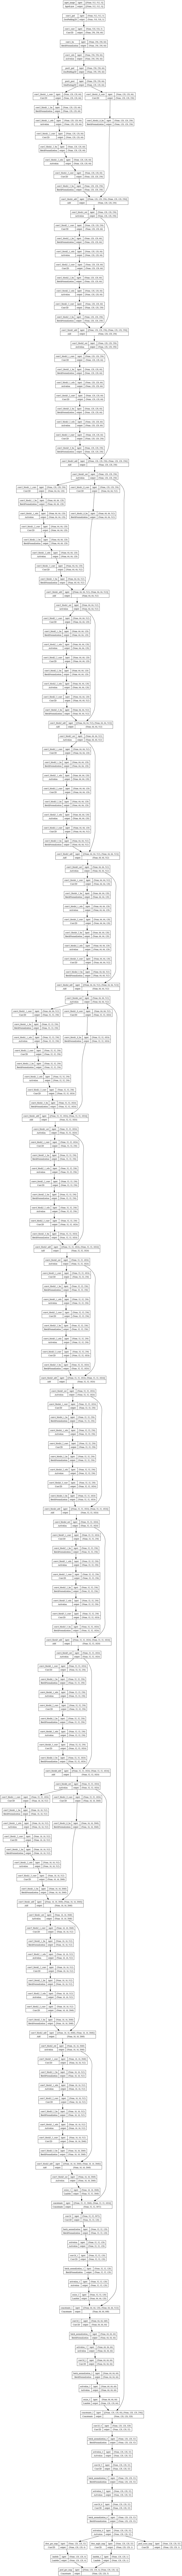

In [9]:
tf.keras.utils.plot_model(east.model, to_file='east.png', show_shapes=True, show_layer_names=True)

In [8]:
def dice_loss(overly_small_text_region_training_mask, text_region_boundary_training_mask, loss_weight, small_text_weight, score_y_true, score_y_pred):
  eps = 1e-5
  _training_mask = tf.minimum(overly_small_text_region_training_mask + small_text_weight, 1) * text_region_boundary_training_mask
  intersection = tf.reduce_sum(score_y_true * score_y_pred * _training_mask)
  union = tf.reduce_sum(score_y_true * _training_mask) + tf.reduce_sum(score_y_pred * _training_mask) + eps
  loss = 1. - (2. * intersection / union)

  return loss * loss_weight

def rbox_loss(overly_small_text_region_training_mask, text_region_boundary_training_mask, small_text_weight, target_score_map, geo_y_true, geo_y_pred):
  # d1 -> top, d2->right, d3->bottom, d4->left
  d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=geo_y_true, num_or_size_splits=5, axis=3)
  d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=geo_y_pred, num_or_size_splits=5, axis=3)
  area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
  area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
  w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
  h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
  area_intersect = w_union * h_union
  area_union = area_gt + area_pred - area_intersect
  L_AABB = -tf.math.log((area_intersect + 1.0) / (area_union + 1.0))
  L_theta = 1 - tf.cos(theta_pred - theta_gt)
  L_g = L_AABB + 20 * L_theta
  _training_mask = tf.minimum(overly_small_text_region_training_mask + small_text_weight, 1) * text_region_boundary_training_mask

  return tf.reduce_mean(L_g * target_score_map * _training_mask)

In [9]:
score_map_loss_weight = tf.Variable(0.01, name='score_map_loss_weight')
small_text_weight = tf.Variable(0., name='small_text_weight')

In [10]:
init_learning_rate = 0.0001
lr_decay_rate = 0.94
lr_decay_steps = 16250


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_learning_rate,
    decay_steps=lr_decay_steps,
    decay_rate=lr_decay_rate,
    staircase=True)

optimizers = tf.optimizers.Adam(lr_schedule)

In [11]:
@tf.function
def train_step(model,
               x,
               optimizer,
               overly_small_text_region_training_mask,
               text_region_boundary_training_mask,
               small_text_weight,
               target_score_map,
               target_geo_maps, loss_weight):
  with tf.GradientTape() as tape:
    score_y_pred, geo_y_pred = model(x)
    _dice_loss = dice_loss(overly_small_text_region_training_mask, text_region_boundary_training_mask, loss_weight, small_text_weight, target_score_map, score_y_pred)
    _rbox_loss = rbox_loss(overly_small_text_region_training_mask, text_region_boundary_training_mask, small_text_weight, target_score_map, target_geo_maps, geo_y_pred)
    loss = _dice_loss + _rbox_loss

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
checkpoint_path = "./east_resnet_50_rbox_22-11"
save_checkpoint_steps = 200

ckpt = tf.train.Checkpoint(step=tf.Variable(0), model=east)
ckpt_manager = tf.train.CheckpointManager(ckpt, directory=checkpoint_path, max_to_keep=5)
latest_ckpt = tf.train.latest_checkpoint(checkpoint_path)

# restore latest checkpoint
if latest_ckpt:
    ckpt.restore(latest_ckpt)
    print('global_step : {}, checkpoint is restored!'.format(int(ckpt.step)))

# set tensorboard summary writer
summary_writer = tf.summary.create_file_writer(checkpoint_path + '/train')

global_step : 0, checkpoint is restored!


In [15]:
train_data_generator = generator(
    training_data_path="data/ICDAR2015/train_data",
    batch_size=2,
    input_size=512,
    background_ratio=0.375,
    is_train=True,
    random_scale=np.array([0.5, 1, 2.0]),
    geometry="RBOX",
    suppress_warnings=True,
    vis=False
)

In [16]:
max_steps = 5000


with tf.device("GPU:0"):
    while int(ckpt.step) < (max_steps + 1):
        # load data
        [input_images, overly_small_text_region_training_masks, text_region_boundary_training_masks, score_maps], \
        [target_score_maps, target_geo_maps] = next(train_data_generator)

        # update parameter
        train_step(east,
                    input_images,
                    optimizers,
                    overly_small_text_region_training_masks,
                    text_region_boundary_training_masks,
                    small_text_weight,
                    target_score_maps,
                    target_geo_maps,
                    score_map_loss_weight
                    )

        score_y_pred, geo_y_pred = east(input_images)
        _dice_loss = dice_loss(overly_small_text_region_training_masks, text_region_boundary_training_masks, score_map_loss_weight,
                                small_text_weight, target_score_maps, score_y_pred)
        _rbox_loss = rbox_loss(overly_small_text_region_training_masks, text_region_boundary_training_masks,
                                small_text_weight, target_score_maps, target_geo_maps, geo_y_pred)
        loss = _dice_loss + _rbox_loss

        print('Step {:06d}, dice_loss {:.4f}, rbox_loss {:.4f}, total_loss {:.4f}'.format(int(ckpt.step), _dice_loss, _rbox_loss, loss))

        if ckpt.step % save_checkpoint_steps == 0:
            # save checkpoint
            ckpt_manager.save(checkpoint_number=ckpt.step)
            print('global_step : {}, checkpoint is saved!'.format(int(ckpt.step)))

            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=int(ckpt.step))
                tf.summary.scalar('pred_score_map_loss', _dice_loss, step=int(ckpt.step))
                tf.summary.scalar('pred_geo_map_loss ', _rbox_loss, step=int(ckpt.step))
                tf.summary.scalar('learning_rate ', optimizers.lr(ckpt.step).numpy(), step=int(ckpt.step))
                tf.summary.scalar('small_text_weight', small_text_weight, step=int(ckpt.step))

                tf.summary.image("input_image", tf.cast((input_images + 1) * 127.5, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("overly_small_text_region_training_mask", tf.cast(overly_small_text_region_training_masks * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("text_region_boundary_training_mask", tf.cast(text_region_boundary_training_masks * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("score_map_target", tf.cast(target_score_maps * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("score_map_pred", tf.cast(score_y_pred * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                for i in range(4):
                    tf.summary.image("geo_map_%d_target" % (i), tf.cast(tf.expand_dims(target_geo_maps[:, :, :, i], axis=3) / input_size * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                    tf.summary.image("geo_map_%d_pred" % (i), tf.cast(tf.expand_dims(geo_y_pred[:, :, :, i], axis=3) / input_size * 255, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("geo_map_4_target", tf.cast((tf.expand_dims(target_geo_maps[:, :, :, 4], axis=3) + 1) * 127.5, tf.uint8), step=int(ckpt.step), max_outputs=3)
                tf.summary.image("geo_map_4_pred", tf.cast((tf.expand_dims(geo_y_pred[:, :, :, 4], axis=3) + 1) * 127.5, tf.uint8), step=int(ckpt.step), max_outputs=3)

        ckpt.step.assign_add(1)

2000 training images in data/ICDAR2015/train_data
Step 000000, dice_loss 0.0100, rbox_loss 0.0098, total_loss 0.0197
global_step : 0, checkpoint is saved!
Step 000001, dice_loss 0.0100, rbox_loss 0.0098, total_loss 0.0197
Step 000002, dice_loss 0.0099, rbox_loss 0.0180, total_loss 0.0279
Step 000003, dice_loss 0.0100, rbox_loss 0.0030, total_loss 0.0130
Step 000004, dice_loss 0.0100, rbox_loss 0.0122, total_loss 0.0221
Step 000005, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000006, dice_loss 0.0100, rbox_loss 0.0047, total_loss 0.0147
Step 000007, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000008, dice_loss 0.0100, rbox_loss 0.0113, total_loss 0.0212
Step 000009, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000010, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000011, dice_loss 0.0099, rbox_loss 0.0334, total_loss 0.0432
Step 000012, dice_loss 0.0099, rbox_loss 0.0193, total_loss 0.0293
Step 000013, dice_loss 0.0100, rbox_loss 

C:\Users\farra\AppData\Local\Temp\ipykernel_6212\1275249081.py:246: RuntimeWarning: invalid value encountered in scalar divide
  return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)


Step 000053, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000054, dice_loss 0.0099, rbox_loss 0.0083, total_loss 0.0183
Step 000055, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000056, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000057, dice_loss 0.0099, rbox_loss 0.0163, total_loss 0.0263
Step 000058, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000059, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000060, dice_loss 0.0100, rbox_loss 0.0068, total_loss 0.0167
Step 000061, dice_loss 0.0100, rbox_loss 0.0042, total_loss 0.0142
Step 000062, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000063, dice_loss 0.0100, rbox_loss 0.0106, total_loss 0.0206
Step 000064, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000065, dice_loss 0.0100, rbox_loss 0.0023, total_loss 0.0123
Step 000066, dice_loss 0.0100, rbox_loss 0.0000, total_loss 0.0100
Step 000067, dice_loss 0.0100, rbox_loss 0.0091, total_loss 0.

In [17]:
east.model.save("./east_resnet_50_rbox_22-11/east_resnet_50_rbox_22-11.h5")

In [8]:
resnet50_east = EAST_model()

ckpt = tf.train.Checkpoint(step=tf.Variable(0), model=resnet50_east)
latest_ckpt = tf.train.latest_checkpoint("./east_resnet_50_rbox_new")

if latest_ckpt:
    ckpt.restore(latest_ckpt)
    print('global_step : {}, checkpoint is restored!'.format(int(ckpt.step)))

global_step : 2000, checkpoint is restored!


In [9]:
import locality_aware_nms as nms_locality

def get_images(test_data_path):
  '''
  find image files in test data path
  :return: list of files found
  '''
  files = []
  exts = ['jpg', 'png', 'jpeg', 'JPG']
  for parent, dirnames, filenames in os.walk(test_data_path):
    for filename in filenames:
      for ext in exts:
        if filename.endswith(ext):
          files.append(os.path.join(parent, filename))
          break
  print('Find {} images'.format(len(files)))
  return files


def resize_image(im, max_side_len=2400):
  '''
  resize image to a size multiple of 32 which is required by the network
  :param im: the resized image
  :param max_side_len: limit of max image size to avoid out of memory in gpu
  :return: the resized image and the resize ratio
  '''
  h, w, _ = im.shape

  resize_w = w
  resize_h = h

  # limit the max side
  if max(resize_h, resize_w) > max_side_len:
    ratio = float(max_side_len) / resize_h if resize_h > resize_w else float(max_side_len) / resize_w
  else:
    ratio = 1.
  resize_h = int(resize_h * ratio)
  resize_w = int(resize_w * ratio)

  resize_h = resize_h if resize_h % 32 == 0 else (resize_h // 32) * 32
  resize_w = resize_w if resize_w % 32 == 0 else (resize_w // 32) * 32
  im = cv2.resize(im, (int(resize_w), int(resize_h)))

  pad_top = (max_side_len - resize_h) // 2
  pad_bottom = max_side_len - resize_h - pad_top
  pad_left = (max_side_len - resize_w) // 2
  pad_right = max_side_len - resize_w - pad_left

  # Pad the resized image
  pad_im = cv2.copyMakeBorder(
    im,
    pad_top, pad_bottom,
    pad_left, pad_right,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0]  # Padding color (black)
  )

  ratio_h = resize_h / float(h)
  ratio_w = resize_w / float(w)

  return im, (ratio_h, ratio_w)


def detect(score_map, geo_map, timer, score_map_thresh=0.7, box_thresh=0.1, nms_thres=0.2):
  '''
  restore text boxes from score map and geo map
  :param score_map:
  :param geo_map:
  :param timer:
  :param score_map_thresh: threshhold for score map
  :param box_thresh: threshhold for boxes
  :param nms_thres: threshold for nms
  :return:
  '''
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, ]
  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)
  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]
  # restore
  start = time.time()
  text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  print('{} text boxes before nms'.format(text_box_restored.shape[0]))
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  timer['restore'] = time.time() - start
  # nms part
  start = time.time()
  boxes = nms_locality.nms_locality(boxes.astype(np.float64), nms_thres)
#   boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thres)
  timer['nms'] = time.time() - start

  if boxes.shape[0] == 0:
    return None, timer

  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
  boxes = boxes[boxes[:, 8] > box_thresh]

  return boxes, timer


def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]

In [16]:
output_dir = "data/ICDAR2015/output_try_train_eastresnet50"

# img_list = get_images("data/ICDAR2015/try_train_data")

img_file = '../train/0000/00287678_2.jpg'
# img_file = '../train/0000/00869256_5.jpg'
# img_file = "data/ICDAR2015/try_train_data/img_9.jpg"

# for img_file in img_list:
img = cv2.imread(img_file)[:, :, ::-1]
start_time = time.time()
img_resized, (ratio_h, ratio_w) = resize_image(img, max_side_len=512)

# img_resized = (img_resized / 127.5) - 1

timer = {'net': 0, 'restore': 0, 'nms': 0}
start = time.time()

# feed image into model
score_map, geo_map = resnet50_east.predict(img_resized[np.newaxis, :, :, :])

timer['net'] = time.time() - start

boxes, timer = detect(score_map=score_map, geo_map=geo_map, timer=timer, score_map_thresh=0.7)

print('{} : net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
    img_file, timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

if boxes is not None:
    boxes = boxes[:, :8].reshape((-1, 4, 2))
    boxes[:, :, 0] /= ratio_w
    boxes[:, :, 1] /= ratio_h

duration = time.time() - start_time
print('[timing] {}'.format(duration))

# save to file
if boxes is not None:
    res_file = os.path.join(output_dir, '{}.txt'.format(os.path.basename(img_file).split('.')[0]))
    # if not os.path.exists(res_file):
    #     os.makedirs(res_file)
    with open(res_file, 'w') as f:
        for box in boxes:
            # to avoid submitting errors
            box = sort_poly(box.astype(np.int32))
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                continue
            f.write('{},{},{},{},{},{},{},{}\r\n'.format(
            box[0, 0], box[0, 1], box[1, 0], box[1, 1], box[2, 0], box[2, 1], box[3, 0], box[3, 1],
            ))
            cv2.polylines(img[:, :, ::-1], [box.astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0), thickness=1)

img_path = os.path.join(output_dir, os.path.basename(img_file))
cv2.imwrite(img_path, img[:, :, ::-1])

1/1 [==============================] - 1s 1s/step
10215 text boxes before nms
../train/0000/00287678_2.jpg : net 1573ms, restore 0ms, nms 1623ms
[timing] 3.206723690032959


True

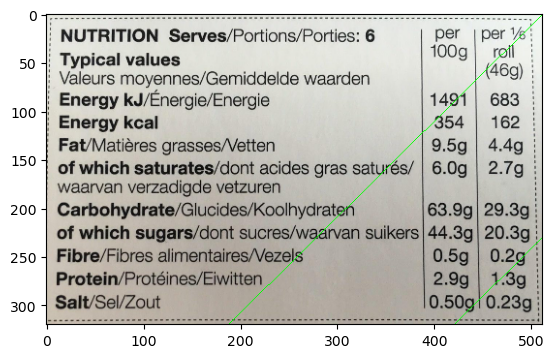

In [17]:
img_resized = cv2.polylines(img_resized, [box.astype(np.int32).reshape((-1, 1, 2))], True, color=(0, 255, 0), thickness=1)
plt.imshow(img_resized)

In [ ]:
# for batch in batches:
#     images, overly_small_masks, boundary_masks, score_maps, geo_maps = batch

# [input_images, overly_small_text_region_training_masks, text_region_boundary_training_masks, score_maps], \
#     [target_score_maps, target_geo_maps] = next(generator_instance)